### Imports

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance

## 1. General Analysis
a) 
X1 - This is an important factor. Higher amounts of given credit could mean that the customer has a good credit history, resulting in a higher credit score, potentially leading to fewer defaults. 
X2-X5 - These demographic features can provide insights into the customer's profile, influencing credit behaviour. While education, marital status and age could affect the possibility of defaulting, if the training data is not representative of the entire population it could create bias and discrimination. 
X6-X11 - Past payment records give a trend of the customer's payment behaviour. A consistent delay (value of 1 or more) could indicate a higher risk of default.
X12-X17 - The amount here reflects a customer's spending behaviour. A combination of a high number here along with a low payment in X18-X23 could indicate financial stress and an inability to make payments, leading to a default.
X18-X23 - The amount here shows how well the customer has been able to meet their payments.

b)
Due to the large number of features (25), it's important to perform feature selection or dimensionality reduction techniques such as PCA to avoid overfitting.
Techniques such as correlation analysis can also be employed to visualize and identify highly correlated features and remove redundant ones.
While irrelevant for a random forest model, feature scaling should also be used. Without it, certain attributes will dominate and cause imbalance, it would also slow down gradient descent.

c)
This task is feasible given the dataset and insightful information on a customer's credit history and behaviour, I believe the features provided directly correlate to whether a customer will default on their next payment or not. The challenging part of this task is modelling the data appropriately while avoiding overfitting or underfitting 

d)
- Perform data exploration and any processing required
- Create new features that could be beneficial to the model
- Decide on performance measures and which to prioritise (explained later)
- Split the dataset into training, validation, and testing sets (70/15/15). As there are only 30,000 rows of data I would like to reserve as much data as possible for training
- Train the base models (LR, SVM, RF)
- Evaluate based on performance metrics and cross-validation
- Tune hyperparameters of models using GridSearch or RandomizedSearch

## 2. Data Exploration, Cleaning and Feature Engineering

### Loading Data

In [4]:
#Load data and skip the X headers
df = pd.read_csv('dataset.csv',skiprows=[0])

#Remove the ID column as it's irrelevant to the model
df.drop(columns=df.columns[0], axis=1,  inplace=True)

#Rename PAY_0 to PAY_1 for consistency and last column to Default
df = df.rename(columns={'PAY_0': 'PAY_1', 'default payment next month': 'DEFAULT'})

X = df.iloc[:, 0:23]  # Independent variables
y = df['DEFAULT']  # Dependent variable

#For random components in modelling
seed = 33

In [5]:
#Visualize the dataframe
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [6]:
#Check for missing or anomalous data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_1      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   3

### a) Data Distribution

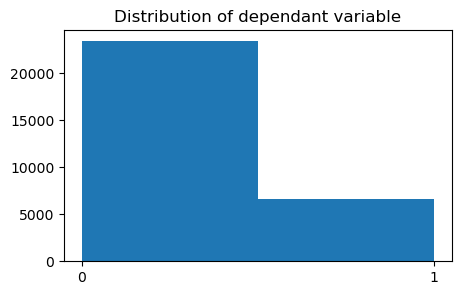

DEFAULT
No Default    23364
Default        6636
Name: count, dtype: int64
Percentage of default:   22.12 %


In [7]:
plt.figure(figsize=(5,3))
plt.hist(df['DEFAULT'], bins=2)
plt.title('Distribution of dependant variable')
plt.xticks([0,1])
plt.show();

class_names = {0:'No Default', 1:'Default'}
print(df.DEFAULT.value_counts().rename(index = class_names))

print("Percentage of default:  ", (df['DEFAULT'].sum() / len(df['DEFAULT'])*100), "%")

Highly imbalanced dataset, no defaults far outnumber defaults. This will addressed later via over/under sampling.

### b) Outliers

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

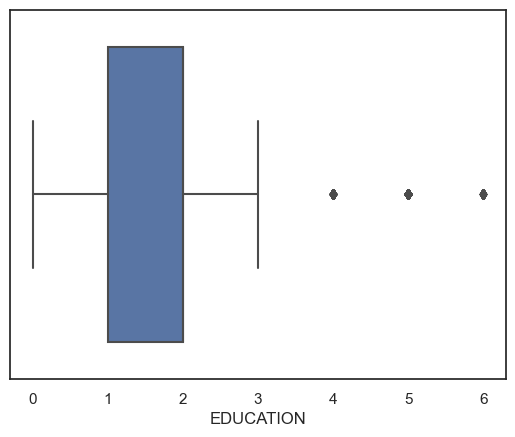

In [70]:
sns.boxplot(x=df['EDUCATION'])
df.EDUCATION.value_counts()

In [71]:
df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE']].describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE
count,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867
std,129747.661567,0.489129,0.790349,0.521970
min,10000.000000,1.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000
50%,140000.000000,2.000000,2.000000,2.000000
75%,240000.000000,2.000000,2.000000,2.000000
max,1000000.000000,2.000000,6.000000,3.000000


Few anomalous data:
- EDUCATION has category 0, 5, 6 that are unlabelled
- MARRIAGE has category 0 unlabelled
- LIMIT_BAL has a very broad range, will need to be dealt with later

In [72]:
print(df['EDUCATION'].value_counts())
print(df['MARRIAGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64
MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64


The 0 in MARRIAGE will be categorized as 'Other' (3)
The 0, 5, 6 in EDUCATION will be categorized as 'Other' (4)

In [73]:
temp = (df['EDUCATION'] == 5) | (df['EDUCATION'] == 6) | (df['EDUCATION'] == 0)
df.loc[temp, 'EDUCATION'] = 4
print(df['EDUCATION'].value_counts())

df.loc[df['MARRIAGE'] == 0, 'MARRIAGE'] = 3
print(df['MARRIAGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64
MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64


### c) Correlations

<Axes: >

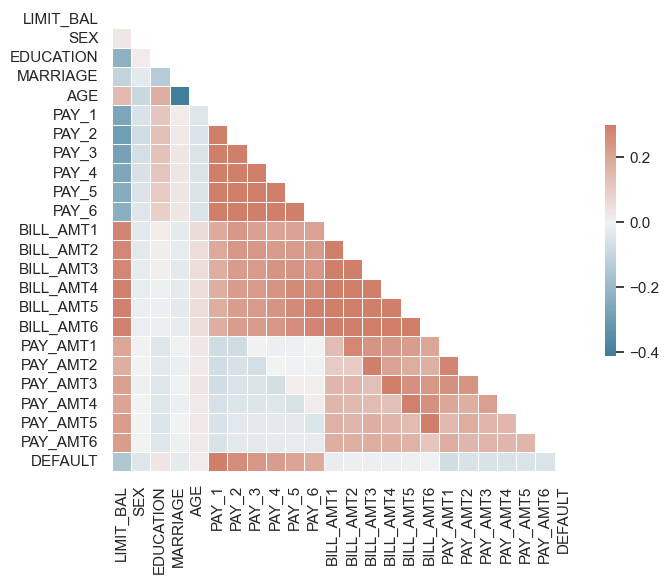

In [74]:
sns.set_theme(style="white")
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#Referenced from Week 4 CreditCardFraud Notebook (Vadgama, 2023)

From this heatmap, we can see the repayment status has a positive correlation with DEFAULT, while the rest have minimal correlation

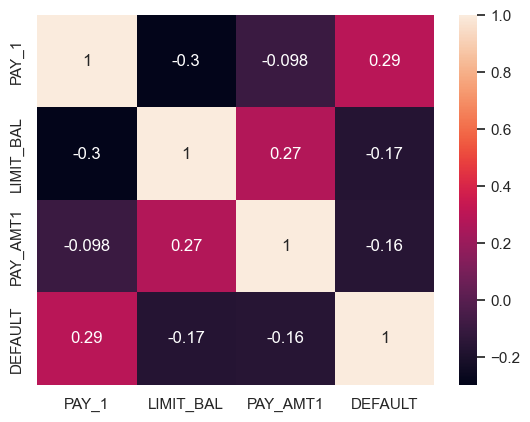

In [75]:
tp = df[['PAY_1', 'LIMIT_BAL', 'PAY_AMT1' ,'DEFAULT']].copy()

correlation_matrix = tp.corr(method='spearman')
sns.heatmap(correlation_matrix, annot=True)
plt.show()

This heatmap makes use of the correlation matrix function with the Spearman's Rank Correlation method, it's appropriate for data that isn't normally distributed and measures the monotonic relationship between two variables. These are some of the variables which have a correlation with DEFAULT.

In [76]:
res = df.groupby(['EDUCATION', 'DEFAULT']).size().unstack()
res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))

print(res)

DEFAULT        0     1      perc
EDUCATION                       
1           8549  2036  0.192348
2          10700  3330  0.237349
3           3680  1237  0.251576
4            435    33  0.070513


With this we can see the higher the level of education, the lower the probability of defaulting, excluding category 4 "others" as an anomaly.

In [77]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']
print(featureScores.nlargest(10,'Score'))

        Specs        Score
5       PAY_1  3537.714970
6       PAY_2  2239.169136
7       PAY_3  1757.466444
8       PAY_4  1476.845967
9       PAY_5  1304.591176
10      PAY_6  1085.402485
0   LIMIT_BAL   724.068539
17   PAY_AMT1   160.403810
18   PAY_AMT2   103.291524
20   PAY_AMT4    97.188000


We can see from the feature selection function provided by scikit-learn that the repayment status for the past few months have a high level of relevance to the target variable.

### d) Feature Engineering

In [78]:
#Categorizing AGE into bins, new column called ageBin as I believe it'll be beneficial to the model

bins = [20, 29, 39, 49, 59, 81]
bins_names = [1, 2, 3, 4, 5]
df['ageBin'] = pd.cut(df['AGE'], bins, labels=bins_names)
df['ageBin'].value_counts()

df['AGE'] = df['ageBin']
df = df.rename(columns={'AGE': 'AGEBIN'})

Ranges are 20-29, 30-39, 40-49, 50-59, 60-81

In [79]:
df = df.drop(columns=['ageBin'])

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGEBIN,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,1,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,1,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,2,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,2,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,4,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [80]:
#Re-set variable X and y
X = df.iloc[:, 0:23]  
y = df['DEFAULT']  

### e) Train, val, test split
Splitting now before scaling ensures the model will be evaluated on unseen data. Scaling the data first could lead to information leakage, introducing information from the test set into the training set.

In [81]:
#Split the dataset into 70/15/15
def train_test_val_split(X, y):
    X_temp, X_train, y_temp, y_train = train_test_split(X, y, test_size=0.7, random_state=seed)

# Then, split the temporary set into validation and test sets (50% of 30% = 15% of total for each)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_test_val_split(X, y)

print(len(X_train))
print(len(X_val))
print(len(X_test))

21000
4500
4500


### e) Data balancing

Just setting the variables in this section, will be performed after hyperparameter tuning to ensure that the hyperparameters are optimized for the balanced distribution.

In [82]:
rus = RandomUnderSampler(random_state=seed)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

smote = SMOTE(random_state=seed)
X_train_SMOTE, y_train_SMOTE = smote.fit_resample(X_train, y_train)

### f) Scaling

In [83]:
scaler = StandardScaler()

#Fit scaler on training data
scaler.fit(X_train)

#Transform training, val, and test data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [84]:

X_train_under_scaled = scaler.fit_transform(X_train_under)
X_train_SMOTE_scaled = scaler.fit_transform(X_train_SMOTE)  

Scaling is required as we'll be using distance based models

## 3. Model Training

### a) Performance Measures

Confusion Matrix

A tool used to evaluate how an algorithm is doing at classifying data. By showing the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). 

                    Predicted Negative     Predicted Positive
ActualNegativee         NP                    PN
ActuaPositiveve        NFP                   

PT
While it's important to minimize both FP and FN and keep a high TP and TN. We want to focus on minimising FN as this element represents the customers we predicted would NOT default, but DID default. 

Several metrics that will be used can also be derived from the confusion matrix:

Accuracy - The proportion of correctly classified instances out of the total
Precision - The proportion of TP over all predicted positives. High precision means a low FP rate
Recall - The proportion of TP among all actual positive instances. High recall indicates a low FN rate
F1 score - The harmonic mean of precision and recall, giving more weight to lower values
Ideally, we do not want to allow any defaults to fall through the cracks, so our optimal model will minimize False Negatives
N


### b) Cross-validation

Cross-validation is a crucial technique for assessing the performance and generalizability of a model. 

In [85]:
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed)))

In [92]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

#Referenced from Week 4 CreditCardFraud Notebook (Vadgama, 2023)

LR: 0.809619 (0.009343)
SVM: 0.817905 (0.008993)
RF: 0.814810 (0.006534)


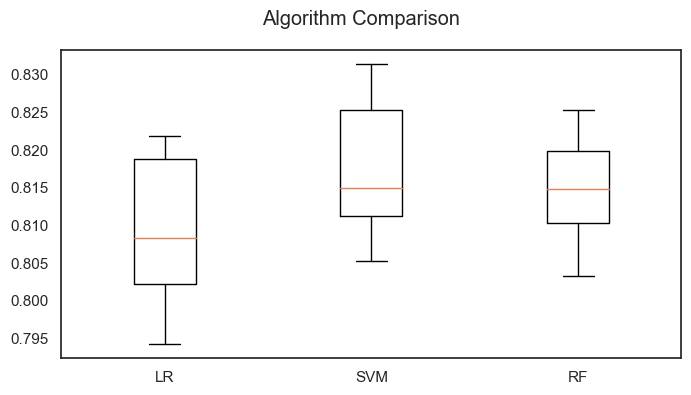

In [94]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
plt.show()

Above are the cross-validation score results, with the first number denoting accuracy and the number in brackets denoting the standard deviation. While the accuracy isn't really high, it is not bad for a base model with cross-validation and 10 folds. With logistic regression performing slightly worse than the support vector machine and random forest model.

Next, we'll run it again but this time with f1 score as the scoring parameter.

In [87]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring="f1")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

#Referenced from Week 4 CreditCardFraud Notebook (Vadgama, 2023)

LR: 0.359199 (0.020598)
SVM: 0.450428 (0.017956)
RF: 0.470512 (0.014867)


Now that we've obtained these baseline results, we know that any change we make to the models should at least outperform these metrics or else it's not worth doing. 

In [88]:
#L2 ridge regularization is applied by default
lr = LogisticRegression(random_state=seed)
lr.fit(X_train_scaled, y_train)

svm = SVC(random_state=seed)
svm.fit(X_train_scaled, y_train)

rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=33)

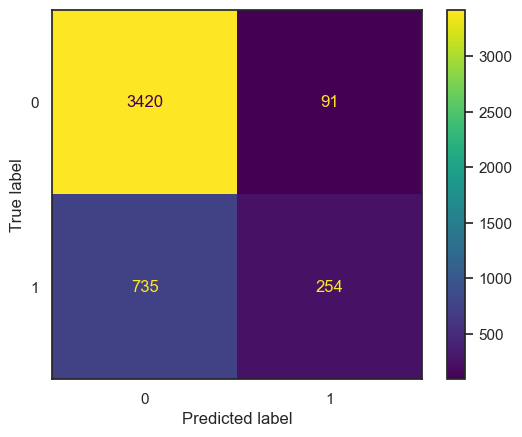

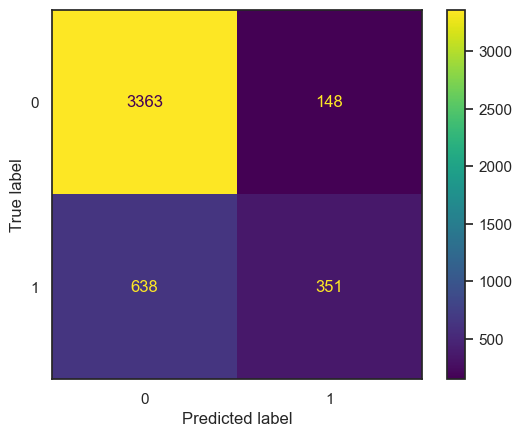

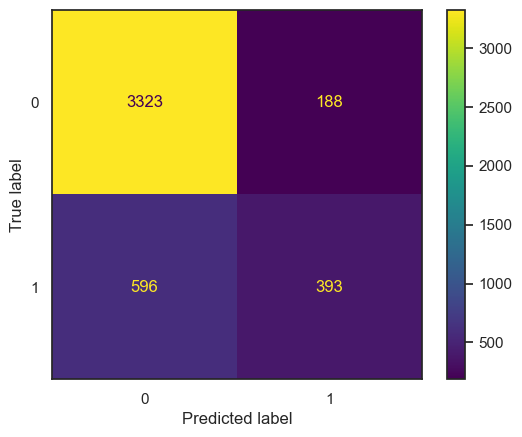

In [89]:
ConfusionMatrixDisplay.from_estimator(lr, X_val_scaled, y_val)
ConfusionMatrixDisplay.from_estimator(svm, X_val_scaled, y_val)
ConfusionMatrixDisplay.from_estimator(rf, X_val_scaled, y_val)

Minimize bottom left quadrant, random forest has the lowest number of false negatives as of now but the highest number of false positives.

In [90]:
y_pred_lr = lr.predict(X_val_scaled)
print(classification_report(y_val, y_pred_lr))

y_pred_svm = svm.predict(X_val_scaled)
print(classification_report(y_val, y_pred_svm))

y_pred_rf = rf.predict(X_val_scaled)
print(classification_report(y_val, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3511
           1       0.74      0.26      0.38       989

    accuracy                           0.82      4500
   macro avg       0.78      0.62      0.64      4500
weighted avg       0.80      0.82      0.78      4500

[[3420   91]
 [ 735  254]]
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3511
           1       0.70      0.35      0.47       989

    accuracy                           0.83      4500
   macro avg       0.77      0.66      0.68      4500
weighted avg       0.81      0.83      0.80      4500

[[3363  148]
 [ 638  351]]
              precision    recall  f1-score   support

           0       0.85      0.95      0.89      3511
           1       0.68      0.40      0.50       989

    accuracy                           0.83      4500
   macro avg       0.76      0.67      0.70      4500
weighted avg       0

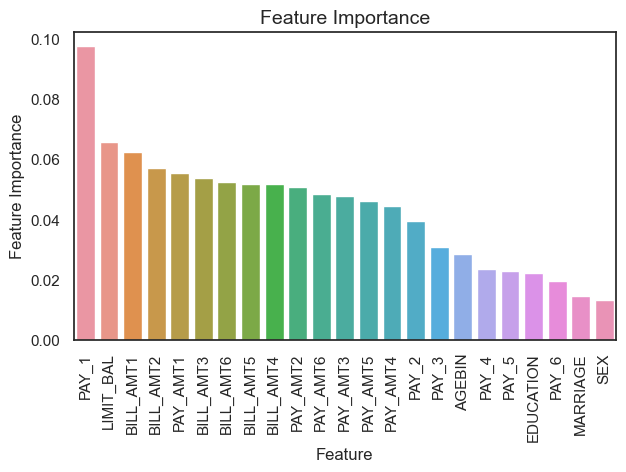

In [91]:
temp = pd.DataFrame({'Feature': list(X.columns), 'Feature Importance': rf.feature_importances_})
temp = temp.sort_values(by="Feature Importance", ascending=False)

plt.figure(figsize=(7,4))
plt.title('Feature Importance', fontsize=14)
s=sns.barplot(x='Feature', y='Feature Importance', data=temp)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.show()

#(Dominguez, 2021)

Attempted to run rf model without the 6 least important features, did not yield any beneficial results therefore will not include

<Axes: ylabel='Feature'>

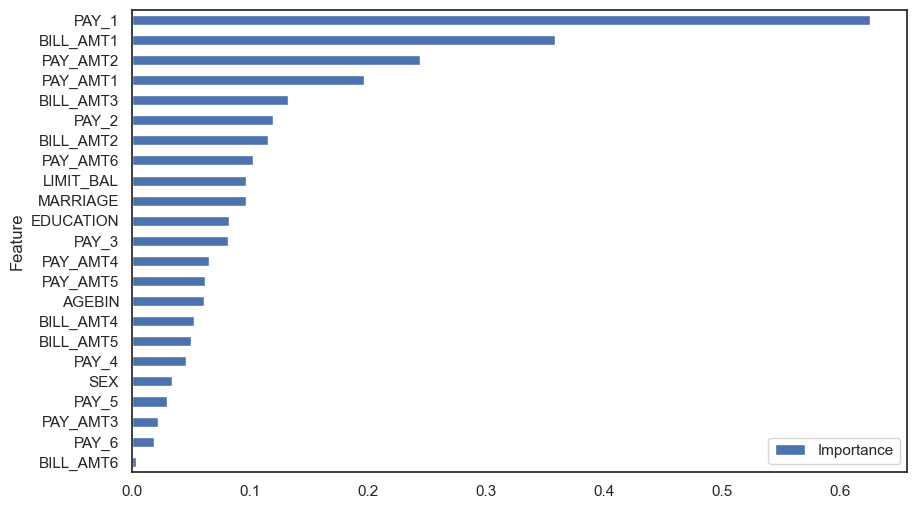

In [95]:
coefficients = lr.coef_[0]

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

Attempted logistic regression with l1 penalty and liblinear solver but did not improve on results

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      3511
           1       0.74      0.26      0.38       989

    accuracy                           0.82      4500
   macro avg       0.78      0.62      0.64      4500
weighted avg       0.80      0.82      0.78      4500



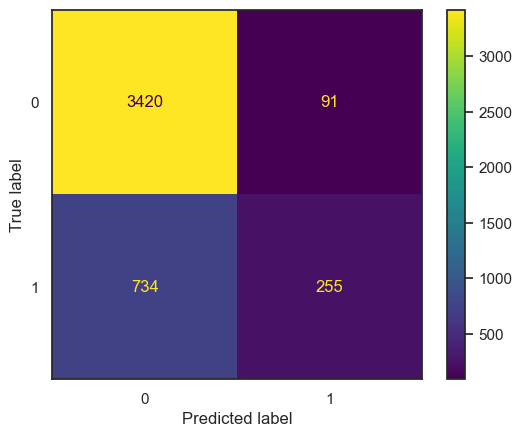

In [102]:
lr_l1 = LogisticRegression(penalty='l1', random_state=seed, solver='liblinear')
lr_l1.fit(X_train_scaled, y_train)

ConfusionMatrixDisplay.from_estimator(lr_l1, X_val_scaled, y_val)
y_pred_lr_l1 = lr_l1.predict(X_val_scaled)
print(classification_report(y_val, y_pred_lr))


### 